In [1]:
### Pytorch geometry (グラフニューラルネットワークライブラリ) のインストール
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

In [2]:
# ライブラリ確認
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem
import torch
from torch_geometric.data import Data as TorchGeometricData

print(Chem.__doc__)

 A module for molecules and stuff

 see Chem/index.html in the doc tree for documentation




In [3]:
#wavefunctionファイルの読み込み
import glob
import re
train_files = []
for file in glob.glob("../calculation/Solubility/train_wavefunction/*_train_wavefunction.npy"):
    train_files.append(file)
test_files = []
for file in glob.glob("../calculation/Solubility/test_wavefunction/*_test_wavefunction.npy"):
    test_files.append(file)
train_num = len(train_files)
test_num = len(test_files)
data_num = train_num + test_num
print("start with {} wavefunctions".format(data_num))



start with 911 wavefunctions


In [5]:
#wavefunctionの取り出し
import psi4

#スレッド数とメモリの設定
psi4.set_num_threads(nthread=5)
psi4.set_memory("10GB")

ID_list = []
wavefunction_list = []
for file in train_files:
    pre_ID = re.findall('../calculation/Solubility/train_wavefunction/(.*)_train_wavefunction.npy', file)
    ID = re.findall('^[0-9]+', pre_ID[0])
    ID_list.append(int(ID[0]))
    wave_function = psi4.core.Wavefunction.from_file(file)
    wavefunction_list.append(wave_function)    
for file in test_files:
    pre_ID = re.findall('../calculation/Solubility/test_wavefunction/(.*)_test_wavefunction.npy', file)
    ID = re.findall('^[0-9]+', pre_ID[0])
    ID_list.append(int(ID[0]))
    wave_function = psi4.core.Wavefunction.from_file(file)
    wavefunction_list.append(wave_function)    

  Threads set to 5 by Python driver.

  Memory set to   9.313 GiB by Python driver.
   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-4, 6-8 entry C          line    61 file /home/kuma/anaconda3/envs/chem/share/psi4/basis/sto-3g.gbs 
    atoms 5        entry O          line    81 file /home/kuma/anaconda3/envs/chem/share/psi4/basis/sto-3g.gbs 
    atoms 9-24     entry H          line    19 file /home/kuma/anaconda3/envs/chem/share/psi4/basis/sto-3g.gbs 

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1        entry O          line    81 file /home/kuma/anaconda3/envs/chem/share/psi4/basis/sto-3g.gbs 
    atoms 2-3, 5-6 entry C          line    61 file /home/kuma/anaconda3/envs/chem/share/psi4/basis/sto-3g.gbs 
    atoms 4        entry N          line    71 file /home/kuma/anaconda3/envs/chem/share/psi4/basis/sto-3g.gbs 
    atoms 7-15     entry H          line    19 file /home/kuma/anaconda3/envs/c

In [6]:
#データのリスト化とソート
data_sets = pd.DataFrame({'ID': ID_list, 'wavefunction': wavefunction_list})
data_sets = data_sets.sort_values('ID')
sort_data_sets = data_sets.reset_index(drop=True)
print(sort_data_sets)

       ID                                       wavefunction
0       1  <psi4.core.Wavefunction object at 0x7f9b8ed0f590>
1       2  <psi4.core.Wavefunction object at 0x7f9b8e521cb0>
2       3  <psi4.core.Wavefunction object at 0x7f9ba092d650>
3       4  <psi4.core.Wavefunction object at 0x7f9b8f638110>
4       5  <psi4.core.Wavefunction object at 0x7f9b8d3378f0>
..    ...                                                ...
906  1233  <psi4.core.Wavefunction object at 0x7f9b8d854890>
907  1237  <psi4.core.Wavefunction object at 0x7f9b87d6e8f0>
908  1242  <psi4.core.Wavefunction object at 0x7f9b8c8fb170>
909  1253  <psi4.core.Wavefunction object at 0x7f9b8d337170>
910  1258  <psi4.core.Wavefunction object at 0x7f9b87d6eb30>

[911 rows x 2 columns]


In [17]:
"""元データの読み込み"""
#分子の読み込み
suppl_train = Chem.SDMolSupplier('../calculation/Solubility/sdf_data/solubility.train.sdf')
train_mols = [x for x in suppl_train]

suppl_test = Chem.SDMolSupplier('../calculation/Solubility/sdf_data/solubility.test.sdf')
test_mols = [x for x in suppl_test]

#情報の整理
train_datasets = []
train_props = []
for prop in train_mols[0].GetPropNames():
     train_props.append(prop)
train_props.append('mol')
for mol in train_mols :
    dataset = []
    for prop in mol.GetPropNames() :
        dataset.append(mol.GetProp(prop))
    dataset.append(mol)
    train_datasets.append(dataset)

train_df = pd.DataFrame(train_datasets, columns=train_props)

test_datasets = []
test_props = []
for prop in test_mols[0].GetPropNames():
     test_props.append(prop)
test_props.append('mol')  
for mol in test_mols :
    dataset = []
    for prop in mol.GetPropNames() :
        dataset.append(mol.GetProp(prop))
    dataset.append(mol)
    test_datasets.append(dataset)

test_df = pd.DataFrame(test_datasets, columns=test_props)

train_data = train_df.loc[:,['ID','smiles','SOL_classification','mol']]
test_data = test_df.loc[:,['ID','SMILES','SOL_classification','mol']]
test_data = test_data.rename(columns = {'SMILES': 'smiles'})

marge_data = pd.concat([train_data, test_data])

org_ID_list = []
org_smiles_list = []
org_sol_list = []
org_mol_list = []
for (ID, smile, sol, mol) in zip(marge_data.ID, marge_data.smiles, marge_data.SOL_classification, marge_data.mol):
    org_ID_list.append(int(ID))
    org_smiles_list.append(smile)
    if sol == "(C) high":
        org_sol_list.append(1.0)
    else:
        org_sol_list.append(0.0)
    org_mol_list.append(mol)
mod_data = pd.DataFrame(list(zip(org_ID_list,org_smiles_list, org_sol_list,org_mol_list)), columns = ['ID','smiles','sol','mol'])

sort_data = mod_data.sort_values('ID')
sort_data = sort_data.reset_index(drop=True)
print(sort_data)


        ID                                             smiles  sol  \
0        1                                              CCCCC  0.0   
1        2                                            C1CCCC1  0.0   
2        3                                             CCCCCC  0.0   
3        4                                           CCCC(C)C  0.0   
4        5                                           CCC(C)CC  0.0   
...    ...                                                ...  ...   
1277  1292  O=C(NCC(=O)O)CCC(C(C(C(C(C(C(C(C1)CC(O)C2)(C2)...  0.0   
1278  1293  c12C(=O)C3=C(O)C4(O)C(=O)C=C(O)C(N(C)C)C4CC3C(...  0.0   
1279  1294  C1C(=O)C=C2CCC3C4CCC(O)(C(=O)COC(=O)CC(C)(C)C)...  0.0   
1280  1295  C1C(O)CC2=CCC3C4CC5OC6(OCC(C)CC6)C(C)C5C4(C)CC...  0.0   
1281  1296  O1C(C)C(O)C(N)C(O)C1OC2C=CC=CC=CC=CCC(C)OC(=O)...  0.0   

                                                   mol  
0     <rdkit.Chem.rdchem.Mol object at 0x7f9b84dec3a0>  
1     <rdkit.Chem.rdchem.Mol object at 0x7f9b

In [19]:
#smiles & activityの取得
original_df = sort_data
smiles_list = []
act_list = []
mol_list = []
for ID in sort_data_sets.ID :
    same_df = original_df.query('ID == @ID')
    smile = same_df['smiles'].values[0]
    act = same_df['sol'].values[0]
    mol = same_df['mol'].values[0]
    smiles_list.append(smile)
    act_list.append(float(act))
    mol_list.append(mol)
    
sort_data_sets['smiles'] = smiles_list
sort_data_sets['activity'] = act_list
sort_data_sets['mol'] = mol_list
print(sort_data_sets)

       ID                                       wavefunction  \
0       1  <psi4.core.Wavefunction object at 0x7f9b8ed0f590>   
1       2  <psi4.core.Wavefunction object at 0x7f9b8e521cb0>   
2       3  <psi4.core.Wavefunction object at 0x7f9ba092d650>   
3       4  <psi4.core.Wavefunction object at 0x7f9b8f638110>   
4       5  <psi4.core.Wavefunction object at 0x7f9b8d3378f0>   
..    ...                                                ...   
906  1233  <psi4.core.Wavefunction object at 0x7f9b8d854890>   
907  1237  <psi4.core.Wavefunction object at 0x7f9b87d6e8f0>   
908  1242  <psi4.core.Wavefunction object at 0x7f9b8c8fb170>   
909  1253  <psi4.core.Wavefunction object at 0x7f9b8d337170>   
910  1258  <psi4.core.Wavefunction object at 0x7f9b87d6eb30>   

                                      smiles  activity  \
0                                      CCCCC       0.0   
1                                    C1CCCC1       0.0   
2                                     CCCCCC       0.0   

In [20]:
#activityのカウント
pd.value_counts(sort_data_sets.activity)

0.0    688
1.0    223
Name: activity, dtype: int64

In [ ]:
"""
0.0    688
1.0    223
Name: activity, dtype: int64
"""

In [21]:
#detaの分割
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(sort_data_sets, random_state=0)
train, val = train_test_split(train_val)

In [ ]:
"""
///////wavefunctionの導入///////
"""

In [28]:
## pandasのデータフレームからRDkitのmolオブジェクトXとラベルYのペアに変換

Xwf={dataset_keyword:[] for dataset_keyword in ["train","valid","test"]}
Ywf={dataset_keyword:[] for dataset_keyword in ["train","valid","test"]}
Zwf={dataset_keyword:[] for dataset_keyword in ["train","valid","test"]}
for (mol, act, wf) in zip(train.mol, train.activity, train.wavefunction):
    mol = Chem.AddHs(mol)  
    Xwf["train"].append(mol)
    Ywf["train"].append(act)
    Zwf["train"].append(wf)
for (mol, act, wf) in zip(val.mol, val.activity, val.wavefunction):
    mol = Chem.AddHs(mol) 
    Xwf["valid"].append(mol)
    Ywf["valid"].append(act)
    Zwf["valid"].append(wf)
for (mol, act, wf) in zip(test.mol, test.activity, test.wavefunction):
    mol = Chem.AddHs(mol) 
    Xwf["test"].append(mol)
    Ywf["test"].append(act)
    Zwf["test"].append(wf)

In [29]:

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception(
            "input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def get_atom_features(atom, en_list=None, explicit_H=False, use_sybyl=False, use_electronegativity=False,
                  use_gasteiger=False, degree_dim=17):
    if use_sybyl:
        atom_type = ordkit._sybyl_atom_type(atom)
        atom_list = ['C.ar', 'C.cat', 'C.1', 'C.2', 'C.3', 'N.ar', 'N.am', 'N.pl3', 'N.1', 'N.2', 'N.3', 'N.4', 'O.co2',
                     'O.2', 'O.3', 'S.O', 'S.o2', 'S.2', 'S.3', 'F', 'Si', 'P', 'P3', 'Cl', 'Br', 'Mg', 'Na', 'Ca',
                     'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                     'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'Unknown']
    else:
        atom_type = atom.GetSymbol()
        atom_list = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V',
                     'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni',
                     'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'Unknown']
    results = one_of_k_encoding_unk(atom_type, atom_list) + \
        one_of_k_encoding(atom.GetDegree(), list(range(degree_dim))) + \
        one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
        [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
        one_of_k_encoding_unk(atom.GetHybridization(),
                              [Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                               Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                               Chem.rdchem.HybridizationType.SP3D2]) + \
        [atom.GetIsAromatic()]

    if use_electronegativity:
        results = results + [en_list[atom.GetAtomicNum() - 1]]
    if use_gasteiger:
        gasteiger = atom.GetDoubleProp('_GasteigerCharge')
        if np.isnan(gasteiger) or np.isinf(gasteiger):
            gasteiger = 0  # because the mean is 0
        results = results + [gasteiger]

    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
        results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])
    return np.array(results, dtype=np.float32)

def get_bond_features(bond):
  results=one_of_k_encoding_unk(bond.GetBondType(),[Chem.rdchem.BondType.SINGLE,
                         Chem.rdchem.BondType.DOUBLE,
                         Chem.rdchem.BondType.TRIPLE,
                         Chem.rdchem.BondType.AROMATIC])
  return np.array(results, dtype=np.float32)

In [30]:
import torch
from rdkit import Chem
from torch_geometric.data import Data as TorchGeometricData
from torch_geometric.data import DataLoader

def get_edge_features(mol):
    edge_list= []
    num_bond_features=0
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_features = get_bond_features(bond)
        num_bond_features=len(bond_features)
        edge_list += [([i, j],bond_features), ([j, i],bond_features)]
    return edge_list, num_bond_features

#modified mol2geodata
#規格化関数
def rescaling(features):
    norm_features = []
    max_value = max(features)
    min_value = min(features)
    for feature in features:
        norm_feature = (feature - min_value)/(max_value - min_value)
        norm_features.append(norm_feature)
    
    return norm_features

def get_WF_results(wf):
    #Mulliken電荷
    psi4.oeprop(wf, "MULLIKEN_CHARGES")
    M_charges = np.array(wf.atomic_point_charges())
    norm_M_charges = rescaling(M_charges)
    #Löwdin電荷
    psi4.oeprop(wf, "LOWDIN_CHARGES")
    L_charges = np.array(wf.atomic_point_charges())
    norm_L_charges = rescaling(L_charges)
    #wf_molecule
    wf_mol = wf.molecule()
    wf_atom_num = wf_mol.natom()
    x_dem_list = []
    y_dem_list = []
    z_dem_list = []
    for num in list(range(wf_atom_num)):
        xyz = wf_mol.xyz(num)
        #x
        if xyz[0] < 0:
            x_dem_list.append(0)
        else:
            x_dem_list.append(1)
        #y
        if xyz[1] < 0:
            y_dem_list.append(0)
        else:
            y_dem_list.append(1)
        #z
        if xyz[2] < 0:
            z_dem_list.append(0)
        else:
            z_dem_list.append(1)
    x_dems = np.array(x_dem_list)
    y_dems = np.array(y_dem_list)
    z_dems = np.array(z_dem_list)
    #energy
    #energy = wf.energy()
    #homo/lumo
    LUMO_idx = wf.nalpha()
    HOMO_idx = LUMO_idx - 1
    homo = wf.epsilon_a_subset("AO", "ALL").np[HOMO_idx]
    lumo = wf.epsilon_a_subset("AO", "ALL").np[LUMO_idx]
    HLgap = lumo-homo
    #結果のまとめ                           
    WF_results = [np.array([Mcharge,Lcharge,x_dem,y_dem,z_dem,homo,lumo,HLgap], dtype=np.float32) for (Mcharge,Lcharge,x_dem,y_dem,z_dem) in zip(norm_M_charges, norm_L_charges,x_dems,y_dems,z_dems)]
    
    return WF_results

def mol2geodataWF(mol,y,z):
    smile = Chem.MolToSmiles(mol)
    atom_features =[get_atom_features(atom) for atom in mol.GetAtoms()]
    WF_results = get_WF_results(z)
    atom_features = np.append(atom_features, WF_results, axis=1)
    num_atom_features=len(atom_features[0])
    atom_features = torch.FloatTensor(atom_features).view(-1, len(atom_features[0]))

    edge_list,num_bond_features = get_edge_features(mol)
    edge_list=sorted(edge_list)
    
    edge_indices=[e for e,v in edge_list]
    edge_attributes=[v for e,v in edge_list]
    edge_indices = torch.tensor(edge_indices)
    edge_indices = edge_indices.t().to(torch.long).view(2, -1)
    edge_attributes = torch.FloatTensor(edge_attributes)
    #print(num_atom_features,num_bond_features)
    return TorchGeometricData(x=atom_features, edge_index=edge_indices, edge_attr=edge_attributes, num_atom_features=num_atom_features,num_bond_features=num_bond_features,smiles=smile, y=y)  

In [31]:
train_data_list = [mol2geodataWF(mol,y,z) for mol,y,z in zip(Xwf["train"],Ywf["train"],Zwf["train"])]
train_loader = DataLoader(train_data_list, batch_size=128,shuffle=True)

valid_data_list = [mol2geodataWF(mol,y,z) for mol,y,z in zip(Xwf["valid"],Ywf["valid"],Zwf["valid"])]
valid_loader = DataLoader(valid_data_list, batch_size=128,shuffle=True)

test_data_list = [mol2geodataWF(mol,y,z) for mol,y,z in zip(Xwf["test"],Ywf["test"],Zwf["test"])]
test_loader = DataLoader(test_data_list, batch_size=128,shuffle=True)

In [32]:
#data check
print(train_data_list[0].smiles)
print(train_data_list[0].x[0])

[H]N=C(N([H])[H])N([H])[N+](=O)[O-]
tensor([ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000, -1.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.3091,  0.0915,  0.0000,  1.0000,  1.0000, -0.3110,  0.1716])


In [33]:
num_atom_features = train_data_list[0].num_atom_features
num_bond_features = train_data_list[0].num_bond_features

print("num_atom_features =",num_atom_features)
print("num_bond_features =",num_bond_features)

num_atom_features = 88
num_bond_features = 4


In [34]:
# ニューラルネットワークの構造の定義

import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU
import torch_geometric.transforms as T
from torch_geometric.nn import NNConv, Set2Set

dim = 64 # 中間層の次元

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin0 = torch.nn.Linear(num_atom_features, dim)

        nn = Sequential(Linear(num_bond_features, 128), ReLU(), Linear(128, dim * dim))
        self.conv = NNConv(dim, dim, nn, aggr='mean')
        self.gru = GRU(dim, dim)

        self.set2set = Set2Set(dim, processing_steps=3)
        self.lin1 = torch.nn.Linear(2 * dim, dim)
        self.lin2 = torch.nn.Linear(dim, 1)

    def forward(self, data):
        out = F.relu(self.lin0(data.x))
        h = out.unsqueeze(0)

        for i in range(3):
            m = F.relu(self.conv(out, data.edge_index, data.edge_attr))
            out, h = self.gru(m.unsqueeze(0), h)
            out = out.squeeze(0)

        out = self.set2set(out, data.batch)
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        return out.view(-1)

In [35]:
# ニューラルネットワークの学習パラメータの定義

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.7, patience=5,min_lr=0.00001)
loss_function = torch.nn.BCEWithLogitsLoss()

def train_step(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_function(model(data), data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def test_step(loader):
    model.eval()
    loss_all = 0
    for data in loader:
        data = data.to(device)
        loss = loss_function(model(data), data.y)
        loss_all += loss.item() * data.num_graphs
    return loss_all / len(loader.dataset)

In [43]:
# 学習開始

best_valid_loss = None
epoch_list = []
loss_list = []
VL_list = []
TL_list = []

for epoch in range(300):
    lr = scheduler.optimizer.param_groups[0]['lr']
    loss = train_step(epoch)
    valid_loss = test_step(valid_loader)
    scheduler.step(valid_loss)

    if best_valid_loss is None or valid_loss <= best_valid_loss:
        test_loss = test_step(test_loader)
        best_valid_loss = valid_loss

    print('Epoch: {:03d}, LR: {:7f}, Loss: {:.7f}, Validation loss: {:.7f}, '
          'Test loss: {:.7f}'.format(epoch, lr, loss, valid_loss, test_loss))
    epoch_list.append(epoch)
    loss_list.append(loss)
    VL_list.append(valid_loss)
    TL_list.append(test_loss)

Epoch: 000, LR: 0.000010, Loss: 0.0992724, Validation loss: 0.5171109, Test loss: 0.3650729
Epoch: 001, LR: 0.000010, Loss: 0.0990762, Validation loss: 0.5176958, Test loss: 0.3650729


KeyboardInterrupt: 

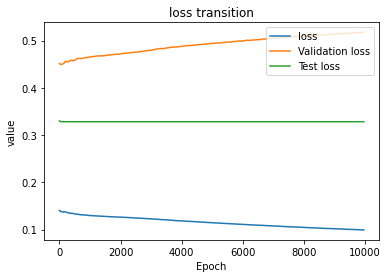

In [39]:
import matplotlib.pyplot as plt

plt.title('loss transition')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.plot(epoch_list,loss_list,label="loss")
plt.plot(epoch_list,VL_list,label="Validation loss")
plt.plot(epoch_list,TL_list,label="Test loss")
plt.legend()
plt.show()

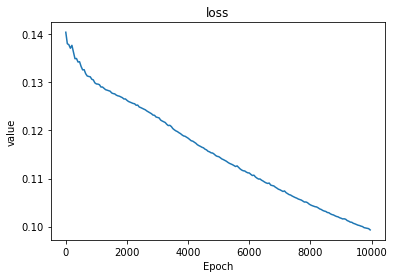

In [40]:
plt.title('training carve')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.plot(epoch_list,loss_list,)
plt.show()

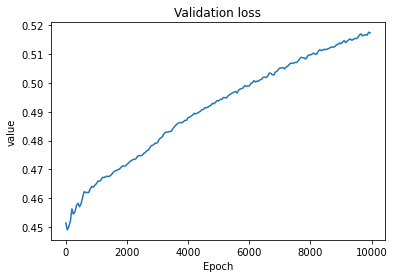

In [41]:
plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.plot(epoch_list,VL_list)
plt.show()

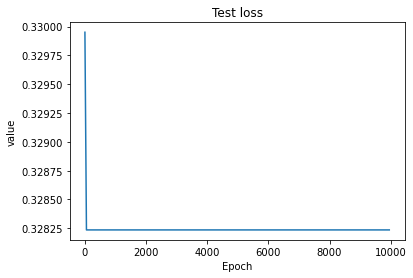

In [42]:
plt.title('Test loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.plot(epoch_list,TL_list)
plt.show()